## Gene regulatory network using single cell RNA/ATAC data (multi-modal)

## FigR

### Installation

The following commands will be used to define an environment where figr can be installed (3.8). Please refer to developers for additional versions of R where this package works

In [1]:
# ```
# conda create -y -n figr python=3.8

# conda activate figr
# conda install -c conda-forge r-base=4.1.3
# conda install -c conda-forge r-devtools


# # it is better to install chromVAR first
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# # these packages need to be installed in the main R session, before installing FigR.
# BiocManager::install("chromVAR")
# BiocManager::install("BSgenome.Hsapiens.UCSC.hg19")
# BiocManager::install("ComplexHeatmap")
# BiocManager::install("motifmatchr")

# conda install -c conda-forge r-rmpfr

# install.packages('devtools')
# library('devtools')
# # if r-essentials is not installed, this step will take a bit longer than usual ~10min.
# devtools::install_github("buenrostrolab/FigR")

# # finally installl figR
# devtools::install_github("buenrostrolab/FigR")

# ```

### Activate environment and then install figr using R devtools

### The default analysis of FigR is based on a correlation analysis between ATAC and RNA features, and then filtering based on significance and/or genomic distance to the target genes.

In [3]:
library(FigR)

Loading required package: Matrix

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats,

The data that downloaded belongs to a shareseq dataset, and it is part of the core FigR tutorials.

In [6]:
# Directory where data will be downloaded to
workingDir <- "shareseq"
shareseqZip <- "https://s3.us-east-1.amazonaws.com/vkartha/FigR/FigR_SHAREseq.zip"
print(paste0(workingDir,basename(shareseqZip)))


[1] "shareseqFigR_SHAREseq.zip"


### If the path is not found then we re-download.

In [7]:
p <- paste0(workingDir, '/', basename(shareseqZip))
print(c(p, file.exists(p)))

[1] "shareseq/FigR_SHAREseq.zip" "TRUE"                      


In [8]:
### If the file is not found, the redownload and reprocess
if(!file.exists(p)){
    download.file(url = shareseqZip,
                  destfile = paste0(workingDir, '/', basename(shareseqZip)))
    unzip(paste(workingDir,basename(shareseqZip),sep="/"),exdir = workingDir,overwrite = FALSE)
}
setwd(workingDir)

### Load the data available in the share-seq dataset

In [9]:
ATAC.se <- readRDS("./shareseq_skin_SE_final.rds")
RNAmat <- readRDS("./shareseq_skin_RNAnorm_final.rds") # Normalized
dim(ATAC.se) # Peaks x Cells

[1] 344592  34774

### General filtering of cells based on number of counts

In [10]:
set.seed(123)
cellsToKeep <- sample(colnames(ATAC.se),size = 10000,replace = FALSE)

ATAC.se <- ATAC.se[,cellsToKeep]
RNAmat <- RNAmat[,cellsToKeep]

# Remove genes with zero expression across all cells
RNAmat <- RNAmat[Matrix::rowSums(RNAmat)!=0,]

### Cis-topic assignment (pre-calculated)

In [11]:
dim(RNAmat)

[1] 19016 10000

In [12]:
cisAssign <- readRDS("./shareseq_skin_cisTopicPs.rds")
dim(cisAssign) # Cells x Topics

all(cellsToKeep %in% rownames(cisAssign))

# Subset
cisAssign <- cisAssign[cellsToKeep,]

[1] 34774    55

[1] TRUE

### Calculation of kNN-graph using topics from cisTopic

In [13]:
library(dplyr)
library(FNN)

In [21]:
set.seed(123)
cellkNN <- get.knn(cisAssign,k = 30)$nn.index
dim(cellkNN)
rownames(cellkNN) <- cellsToKeep

[1] 10000    30

### Visualize cells using traditional UMAP

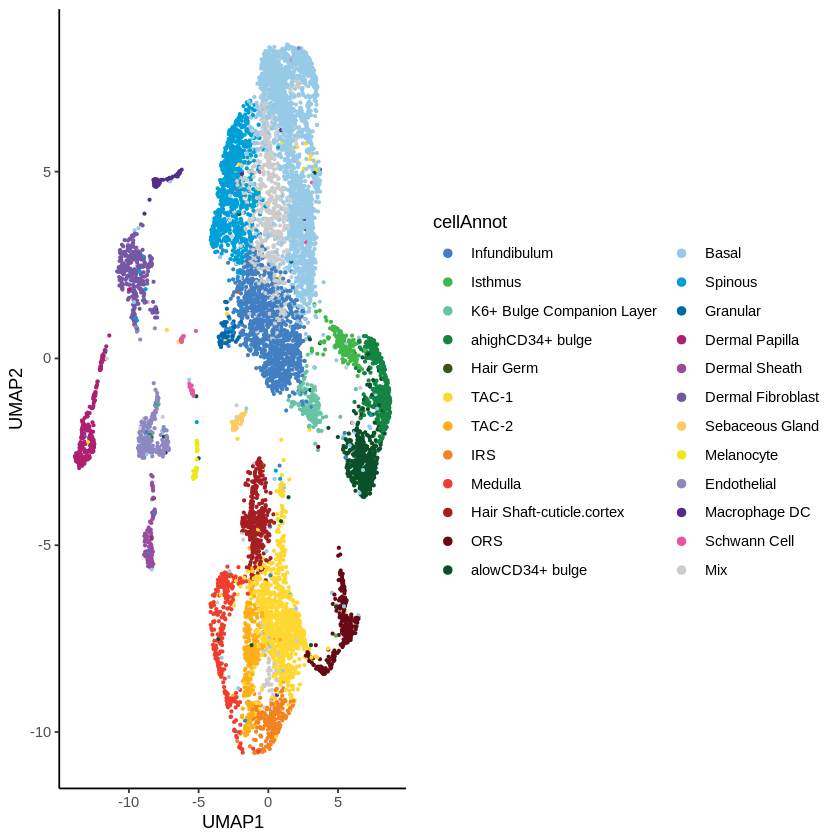

In [13]:
annoCols <- readRDS("./shareseq_skin_annoCols.rds")

# Plot
library(ggplot2)
colData(ATAC.se) %>% as.data.frame() %>% ggplot(aes(UMAP1,UMAP2,color=cellAnnot)) + 
  geom_point(size=0.5) + scale_color_manual(values=annoCols)+
  theme_classic() + guides(colour = guide_legend(override.aes = list(size=2)))

The main FigR algorithm is executed here.

In [14]:
library(BSgenome.Mmusculus.UCSC.mm10)

Loading required package: BSgenome

Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:

    strsplit


Loading required package: rtracklayer



In [14]:
cisCorr <- readRDS("./shareseq_skin_cisCor.rds")

### This snippet will not work in an interactive session (reason to be inspected), and it can only be executed in terminal R

In [ ]:
# Don't run interactively
cisCorr <- FigR::runGenePeakcorr(ATAC.se = ATAC.se,
                           RNAmat = RNAmat,
                           genome = "mm10", # One of hg19, mm10 or hg38 
                           nCores = 1,
                           p.cut = NULL, # Set this to NULL and we can filter later
                           n_bg = 100)
head(cisCorr)

Running DORC scoring for 1475 genes: Notch1, Atf3, Gfpt2, Col1a2, Col3a1, Ifrd1, Emp1, Thbs1, Cyr61, Ezr, Lrig1, Cux1, Gja1, Col1a1, Krt79, Lef1, Meg3, Smad7, Krt17, Adamts1, ... , ... , ... (truncated display)



........
Normalizing scATAC counts ..
Centering counts for cells sequentially in groups of size  5000  ..

Computing centered counts for cells:  1  to  5000 ..
Computing centered counts per cell using mean reads in features ..

Computing centered counts for cells:  5001  to  10000 ..
Computing centered counts per cell using mean reads in features ..

Merging results..
Done!
Computing DORC scores ..
Running in parallel using  4 cores ..

Time Elapsed:  2.06452926397324 mins 



ERROR: Error in nrow(NNmat): object 'cellKNN.mat' not found


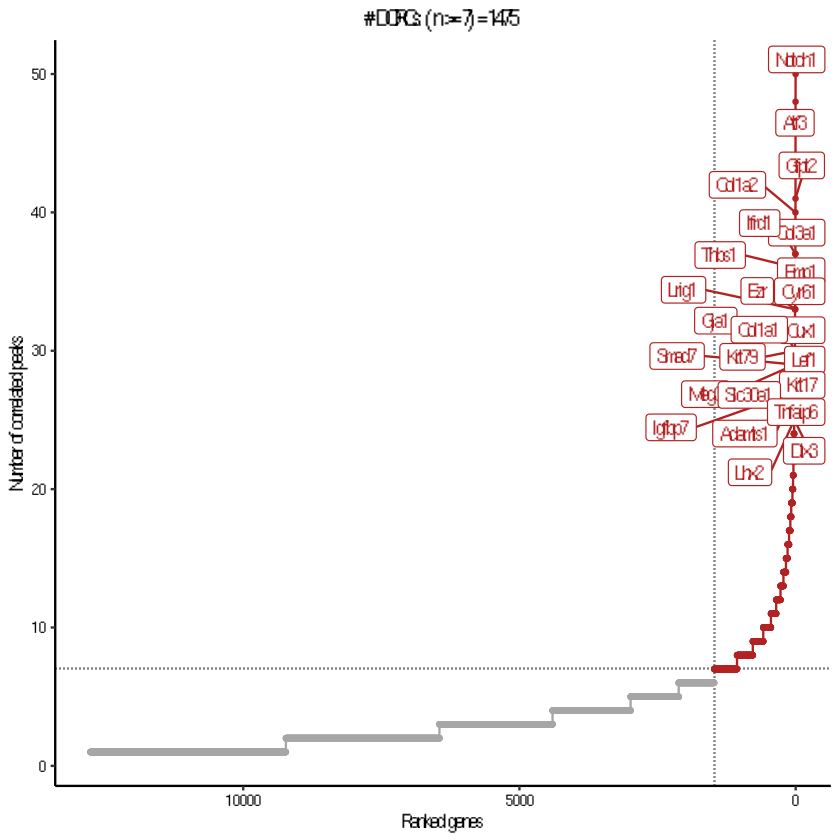

In [15]:
# Filter peak-gene correlations by p-value                    
cisCorr.filt <- cisCorr %>% filter(pvalZ <= 0.05)
# Determine DORC genes
dorcGenes <- cisCorr.filt %>% dorcJPlot(cutoff=7, # Default
                                       returnGeneList = TRUE)
# Get DORC scores
dorcMat <- getDORCScores(ATAC.se,dorcTab=cisCorr.filt,geneList=dorcGenes,nCores=4)
# Smooth DORC scores (using cell KNNs)
dorcMat.smooth <- smoothScoresNN(NNmat=cellKNN.mat,mat=dorcMat,nCores=4)

In [19]:
# to execute the smoothScores NN function, doParallel is required.
library(doParallel)

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



In [22]:
# Smooth dorc scores using cell KNNs (k=30)
dorcMat.s <- smoothScoresNN(NNmat = cellkNN[,1:30],mat = dorcMat,nCores = 4)

# Smooth RNA using cell KNNs
# This takes longer since it's all genes
RNAmat.s <- smoothScoresNN(NNmat = cellkNN[,1:30],mat = RNAmat,nCores = 4)

Number of cells in supplied matrix:  10000 
Number of genes in supplied matrix:  1475 
Number of nearest neighbors being used per cell for smoothing:  30 
  |                                                                      |   0%Running in parallel using  4 cores ..
  |======================================================================| 100%
Merging results ..

Time Elapsed:  1.82716798384984 mins 
Number of cells in supplied matrix:  10000 
Number of genes in supplied matrix:  19016 
Number of nearest neighbors being used per cell for smoothing:  30 
Running smoothing for all genes in matrix! (n = 19016) This is bound to take more time than querying specific markers ..
  |                                                                      |   0%Running in parallel using  4 cores ..
  |======================================================================| 100%
Merging results ..

Time Elapsed:  2.40900606711706 mins 


In [23]:
library(ggplot2)
library(ggrastr)

In [24]:
# Visualize on pre-computed UMAP
umap.d <- as.data.frame(colData(ATAC.se)[,c("UMAP1","UMAP2")])


In [25]:

# DORC score for Dlx3
dorcg <- plotMarker2D(umap.d,dorcMat.s,markers = c("Dlx3"),maxCutoff = "q0.99",colorPalette = "brewer_heat") + ggtitle("Dlx3 DORC")

Plotting  Dlx3 


In [26]:
# RNA for Dlx3
rnag <- plotMarker2D(umap.d,RNAmat.s,markers = c("Dlx3"),maxCutoff = "q0.99",colorPalette = "brewer_purple") + ggtitle("Dlx3 RNA")

Plotting  Dlx3 


In [28]:
library(patchwork)


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots




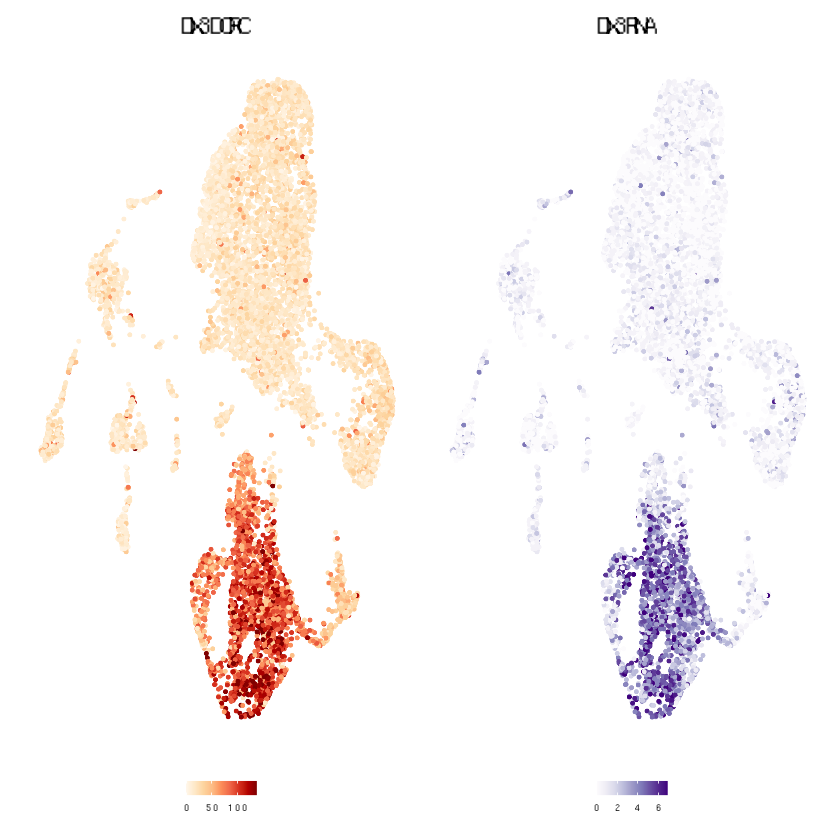

In [29]:
dorcg + rnag


In [30]:
figR.d <- runFigRGRN(ATAC.se = ATAC.se, # Must be the same input as used in runGenePeakcorr()
                     dorcTab = cisCorr.filt, # Filtered peak-gene associations
                     genome = "mm10",
                     dorcMat = dorcMat.s,
                     rnaMat = RNAmat.s, 
                     nCores = 2)

Assuming peak indices in Peak field

Removing genes with 0 expression across cells ..




Getting peak x motif matches ..



Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:

    strsplit




Determining background peaks ..
Using  50  iterations ..

Testing  708  TFs
Testing  1475  DORCs


Running FigR using 2 cores ..




  |======================================================================| 100%Finished!
Merging results ..


### Visualization of main results and further options

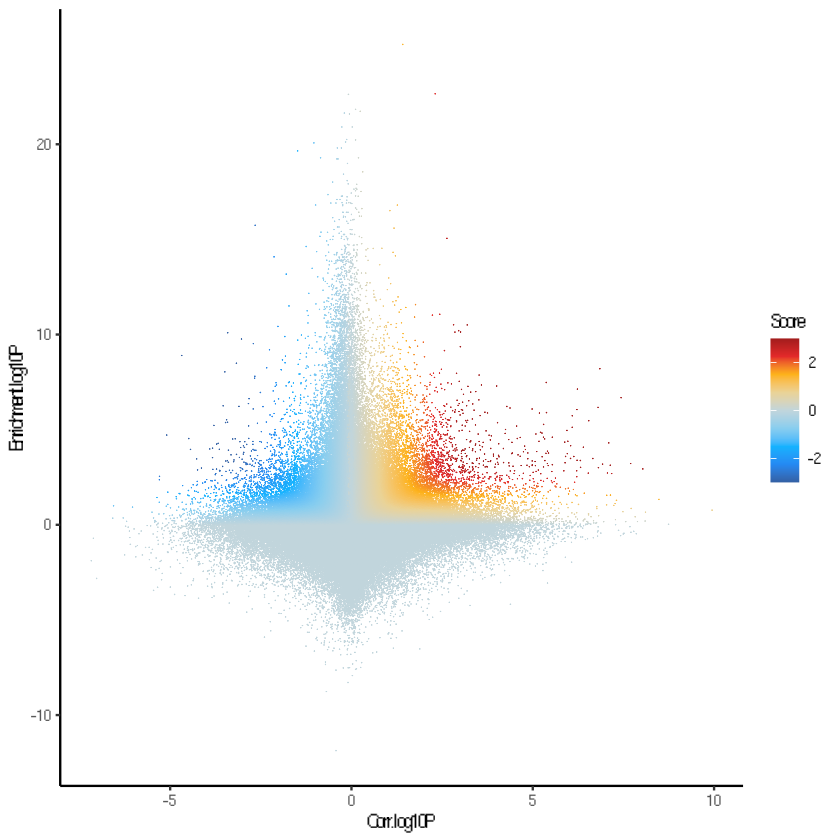

In [35]:
# Visualize all TF-DORC regulation scores (Scatter plot)
require(ggplot2)
require(ggrastr)
require(BuenColors) # https://github.com/caleblareau/BuenColors


figR.d %>% 
  ggplot(aes(Corr.log10P,Enrichment.log10P,color=Score)) + 
  ggrastr::geom_point_rast(size=0.01,shape=16) + 
  theme_classic() + 
  scale_color_gradientn(colours = jdb_palette("solar_extra"),limits=c(-3,3),oob = scales::squish,breaks=scales::breaks_pretty(n=3))

In [36]:
rankDrivers(figR.d,score.cut = 2,rankBy = "nTargets",interactive = TRUE)


Ranking TFs by total number of associated DORCs ..


Using absolute score cut-off of: 2 ..


Warning message:
“`gather_()` was deprecated in tidyr 1.2.0.
Please use `gather()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


HTML widgets cannot be represented in plain text (need html)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



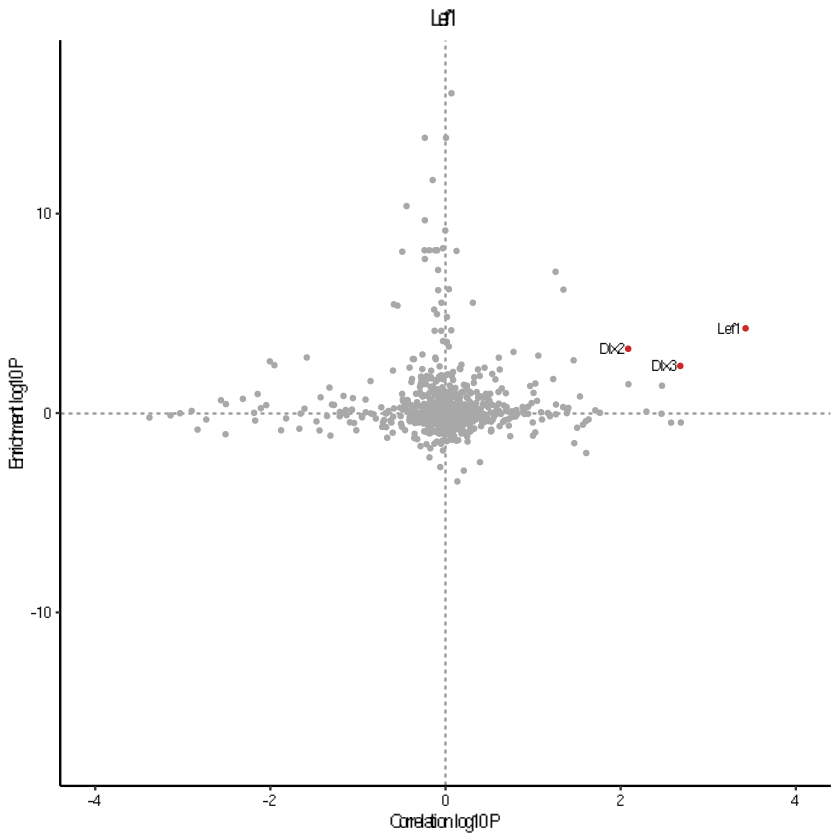

In [37]:
plotDrivers(figR.d,score.cut = 2,marker = "Lef1")


Loading required package: grid


Attaching package: ‘grid’


The following object is masked from ‘package:Biostrings’:

    pattern


ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


Using absolute score cut-off of: 2 ..


Using Score as value column: use value.var to override.

Plotting 754 DORCs x 93TFs




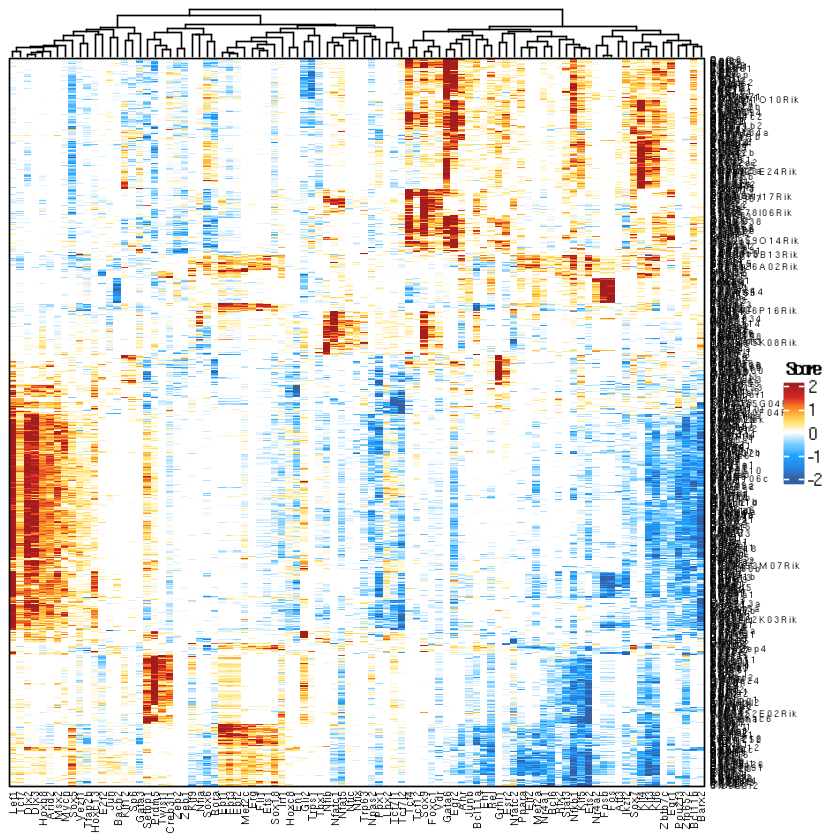

In [38]:
library(ComplexHeatmap)
plotfigRHeatmap(figR.d = figR.d,
                score.cut = 2,
                column_names_gp = gpar(fontsize=6), # from ComplexHeatmap
                show_row_dend = FALSE # from ComplexHeatmap
                )

Using absolute score cut-off of: 1 ..


Using Score as value column: use value.var to override.

Plotting 744 DORCs x 7TFs




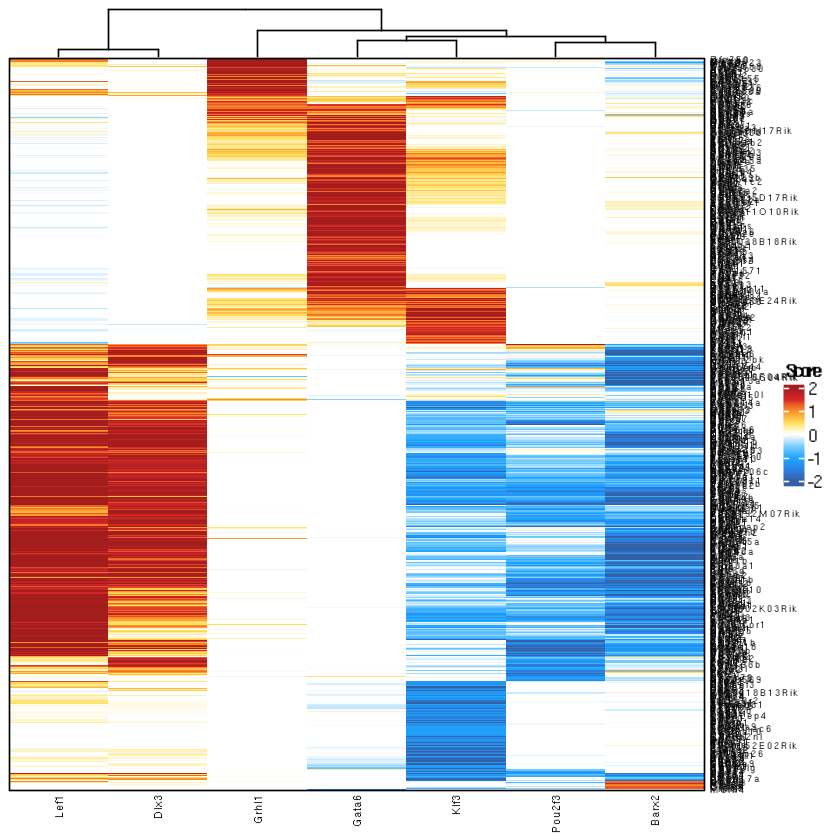

In [39]:
library(ComplexHeatmap)
plotfigRHeatmap(figR.d = figR.d,
                score.cut = 1,
                TFs = c("Lef1","Dlx3","Grhl1","Gata6","Klf3","Barx2","Pou2f3"),
                column_names_gp = gpar(fontsize=6), # from ComplexHeatmap
                show_row_dend = FALSE # from ComplexHeatmap
                )

In [41]:
library(networkD3)

In [43]:
plotfigRNetwork(figR.d,
                score.cut = 2,
                TFs = c("Lef1","Dlx3","Grhl1","Gata6","Klf3","Barx2","Pou2f3"),
                weight.edges = TRUE)

HTML widgets cannot be represented in plain text (need html)

## Key Takeaways

1. Experimental design and analysis
2. Detect global and cluster-specific regulons allows going into types of signal based on how easy and those are to be assessed as significant.
3. Statistical power is increased by generating broad gene groups with at least 100 or more genes per category. Lower gene numbers per group would dissipate the signal, and make the listing of TF-gene associations per cluster more difficult.

## Quiz

1. What is a TF-regulon and in what scenarios it might be worth discovering those?

2. What is the futility theorem? 

3. Are there more motif categories or more transcription factors? How can one reconcile the redundancy of these during the analysis?

4. How can one find cluster specific TF-regulons?

## References